In [1]:
# Standard imports
import numpy as np
import yaml
import toml
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top

telescopes = dict.fromkeys(['CHLAT_20210401.yaml', 'SPLAT_20210401.yaml']) #, 'SAT_pole_20210401.yaml'])

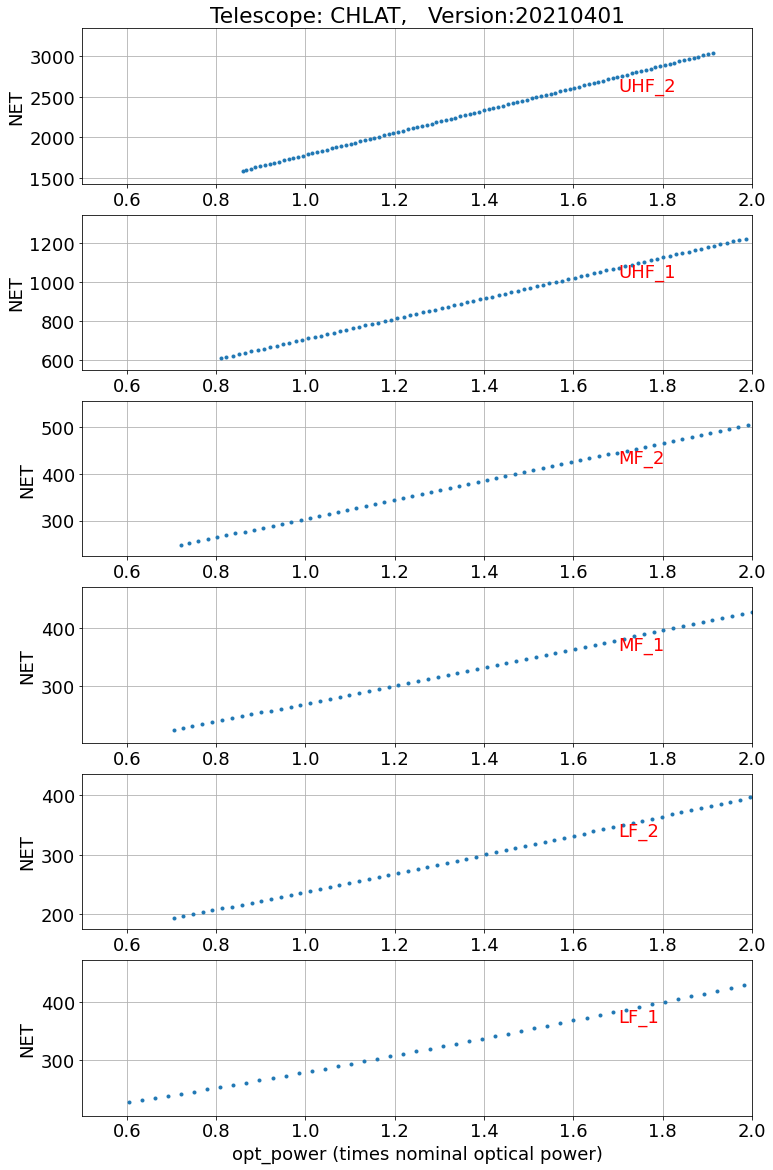

In [2]:
yaml_file = list(telescopes.keys())[0]
dd = yaml.safe_load(open(yaml_file))
version_date = str(dd['version']['date'])
version_telescope = str(dd['version']['name'])
del dd['version']

ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())

#Make dictionary of nominal PSATs. Enter values in pW. 
psat ={}
psat['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
psat['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
psat['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

#convert to Watts
for channel in ch_names:    
    psat[yaml_file.partition('.')[0]][channel] *= 1e-12

#set psat factor to None & delete psat entry from channel default
dd['instrument']['channel_default']['psat_factor'] = None
del dd['instrument']['channel_default']['psat']

#assign SI psat values at the channel level
for channel in ch_names: 
    dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat[yaml_file.partition('.')[0]][channel]

# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'

in_param = 'opt_power'

out_param = 'NET' #
# out_param possible values:
#  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
#  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

#Make dict of nominal optical powers
top = Top(**dd)
top.run()
tabs = top.instrument.tables
nom_opt_pow ={}
for channel in ch_names: 
    nom_opt_pow[channel] = tabs['cam_1_%s_sims' % channel]['opt_power'][0]
    
temp_vec = np.linspace(.00001, 2000, 100)

outputs = {}
outputs[out_param]={}
outputs['opt_power']={} 
for chan in ch_names:
    outputs[out_param][chan]=np.array([])
    outputs['opt_power'][chan]=np.array([])

for temp in temp_vec:
    dd['instrument']['optics_config']['elements']['secondary']['temperature']  = temp
    top = Top(**dd)
    top.run()
    tabs = top.instrument.tables
    for chan in ch_names:
        outputs[out_param][chan] = np.append(outputs[out_param][chan], tabs['cam_1_%s_sims' % chan][out_param].quantity[0])
        outputs['opt_power'][chan] = np.append(outputs['opt_power'][chan], tabs['cam_1_%s_sims' % chan]['opt_power'].quantity[0])
        
#trim arrays to (.5, 2) nominal optical power
for chan in ch_names: 
    for i in range(0, len(outputs['opt_power'][chan])):
        if outputs['opt_power'][chan][i] / nom_opt_pow[chan] > 2.0 or outputs['opt_power'][chan][i] / nom_opt_pow[chan] < 0.5 : 
            outputs['opt_power'][chan][i] = 0.0
            outputs[out_param][chan][i] = 0.0
    outputs['opt_power'][chan] = np.trim_zeros(outputs['opt_power'][chan])
    outputs[out_param][chan] = np.trim_zeros(outputs[out_param][chan])

#save inputs & outputs to tesescope dictionary
io_dict = dict.fromkeys([in_param, out_param])
channel_dict = dict.fromkeys(ch_names)

for chan in ch_names: 
    channel_dict[chan] = io_dict
    channel_dict[chan][in_param] = outputs['opt_power'][chan] 
    channel_dict[chan][out_param] = np.array(outputs[out_param][chan])

telescopes[yaml_file] = channel_dict
    
#plot
plt.clf()
n_chan = len(ch_names)
ii = n_chan

for chan in ch_names:
    plt.subplot(n_chan,1,ii)
    plt.plot(outputs['opt_power'][chan] / nom_opt_pow[chan],outputs[out_param][chan], '.') 
    plt.ylabel(out_param)
    if ii == n_chan:
        plt.xlabel('opt_power' + ' (times nominal optical power)')
    #xmin, xmax, ymin, ymax = plt.axis()
    xmin, xmax, ymin, ymax = plt.axis([.5, 2, np.min(outputs[out_param][chan]) - .1*np.min(outputs[out_param][chan]), np.max(outputs[out_param][chan]) + .1*np.max(outputs[out_param][chan])])
    #plt.xlim(0.5, 2)

    #plt.plot([base_value,base_value],[ymin,ymax],'r')
    xloc = xmin + 0.8*(xmax-xmin)
    yloc = ymin + 0.6*(ymax-ymin)
    plt.text(xloc,yloc,chan,color='r')
    plt.grid()
    ii = ii-1
titlestring = 'Telescope: '+version_telescope+',   Version:'+version_date
plt.title(titlestring)
plt.savefig('plots/' + yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.png', dpi=300)

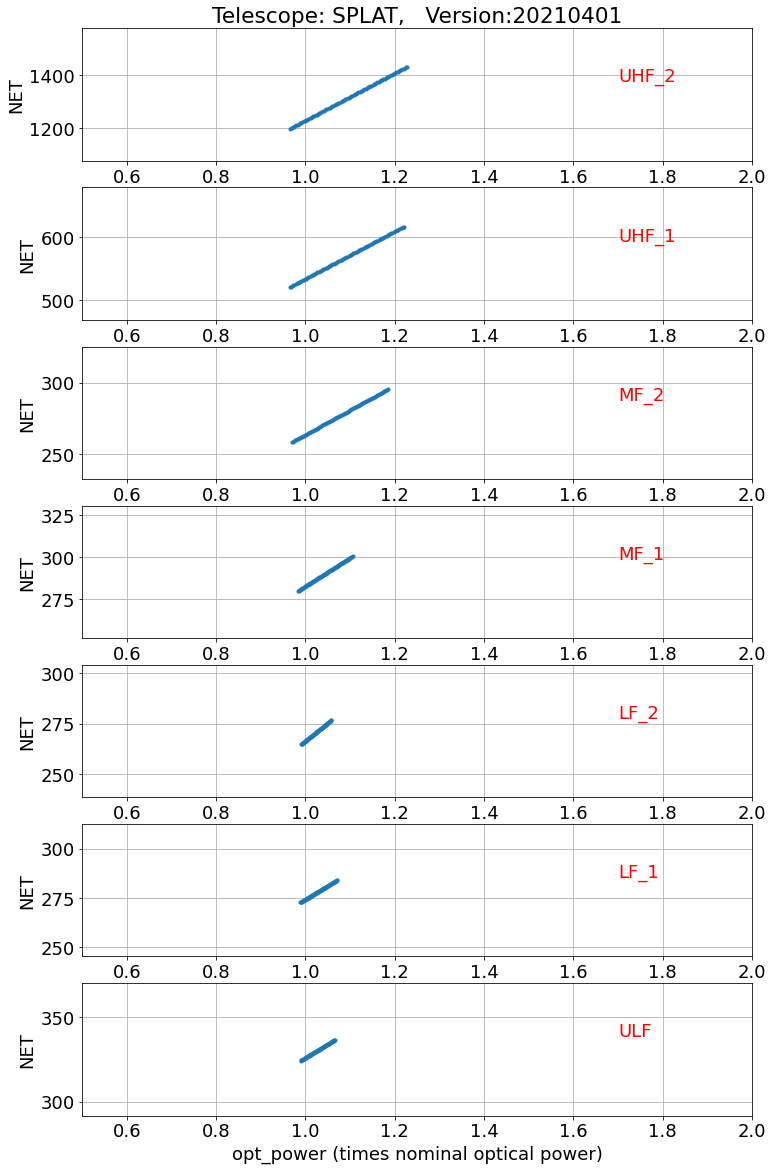

In [3]:
yaml_file = list(telescopes.keys())[1]
dd = yaml.safe_load(open(yaml_file))
version_date = str(dd['version']['date'])
version_telescope = str(dd['version']['name'])
del dd['version']

ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())

#Make dictionary of nominal PSATs. Enter values in pW. 
psat ={}
psat['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
psat['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
psat['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

#convert to Watts
for channel in ch_names:    
    psat[yaml_file.partition('.')[0]][channel] *= 1e-12

#set psat factor to None & delete psat entry from channel default
dd['instrument']['channel_default']['psat_factor'] = None
del dd['instrument']['channel_default']['psat']

#assign SI psat values at the channel level
for channel in ch_names: 
    dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat[yaml_file.partition('.')[0]][channel]

# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'

in_param = 'opt_power'

out_param = 'NET' #
# out_param possible values:
#  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
#  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

#Make dict of nominal optical powers
top = Top(**dd)
top.run()
tabs = top.instrument.tables
nom_opt_pow ={}
for channel in ch_names: 
    nom_opt_pow[channel] = tabs['cam_1_%s_sims' % channel]['opt_power'][0]
    
temp_vec = np.linspace(.00001, 2000, 100)

outputs = {}
outputs[out_param]={}
outputs['opt_power']={} 
for chan in ch_names:
    outputs[out_param][chan]=np.array([])
    outputs['opt_power'][chan]=np.array([])

for temp in temp_vec:
    dd['instrument']['optics_config']['elements']['secondary']['temperature']  = temp
    top = Top(**dd)
    top.run()
    tabs = top.instrument.tables
    for chan in ch_names:
        outputs[out_param][chan] = np.append(outputs[out_param][chan], tabs['cam_1_%s_sims' % chan][out_param].quantity[0])
        outputs['opt_power'][chan] = np.append(outputs['opt_power'][chan], tabs['cam_1_%s_sims' % chan]['opt_power'].quantity[0])
        
#trim arrays to (.5, 2) nominal optical power
for chan in ch_names: 
    for i in range(0, len(outputs['opt_power'][chan])):
        if outputs['opt_power'][chan][i] / nom_opt_pow[chan] > 2.0 or outputs['opt_power'][chan][i] / nom_opt_pow[chan] < 0.5 : 
            outputs['opt_power'][chan][i] = 0.0
            outputs[out_param][chan][i] = 0.0
    outputs['opt_power'][chan] = np.trim_zeros(outputs['opt_power'][chan])
    outputs[out_param][chan] = np.trim_zeros(outputs[out_param][chan])

#save inputs & outputs to tesescope dictionary
io_dict = dict.fromkeys([in_param, out_param])
channel_dict = dict.fromkeys(ch_names)

for chan in ch_names: 
    channel_dict[chan] = io_dict
    channel_dict[chan][in_param] = outputs['opt_power'][chan] 
    channel_dict[chan][out_param] = np.array(outputs[out_param][chan])

telescopes[yaml_file] = channel_dict
    
#plot
plt.clf()
n_chan = len(ch_names)
ii = n_chan

for chan in ch_names:
    plt.subplot(n_chan,1,ii)
    plt.plot(outputs['opt_power'][chan] / nom_opt_pow[chan],outputs[out_param][chan], '.') 
    plt.ylabel(out_param)
    if ii == n_chan:
        plt.xlabel('opt_power' + ' (times nominal optical power)')
    #xmin, xmax, ymin, ymax = plt.axis()
    xmin, xmax, ymin, ymax = plt.axis([.5, 2, np.min(outputs[out_param][chan]) - .1*np.min(outputs[out_param][chan]), np.max(outputs[out_param][chan]) + .1*np.max(outputs[out_param][chan])])
    #plt.xlim(0.5, 2)

    #plt.plot([base_value,base_value],[ymin,ymax],'r')
    xloc = xmin + 0.8*(xmax-xmin)
    yloc = ymin + 0.6*(ymax-ymin)
    plt.text(xloc,yloc,chan,color='r')
    plt.grid()
    ii = ii-1
titlestring = 'Telescope: '+version_telescope+',   Version:'+version_date
plt.title(titlestring)
plt.savefig('plots/' + yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.png', dpi=300)

In [4]:
# yaml_file = list(telescopes.keys())[2]
# dd = yaml.safe_load(open(yaml_file))
# version_date = str(dd['version']['date'])
# version_telescope = str(dd['version']['name'])
# del dd['version']

# ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())

# #Make dictionary of nominal PSATs. Enter values in pW. 
# psat ={}
# psat['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
# psat['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
# psat['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

# #convert to Watts
# for channel in ch_names:    
#     psat[yaml_file.partition('.')[0]][channel] *= 1e-12

# #set psat factor to None & delete psat entry from channel default
# dd['instrument']['channel_default']['psat_factor'] = None
# del dd['instrument']['channel_default']['psat']

# #assign SI psat values at the channel level
# for channel in ch_names: 
#     dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat[yaml_file.partition('.')[0]][channel]

# # location of atmosphere file
# dd['sim_config']['config_dir'] = '../../bolo-calc/config'

# in_param = 'opt_power'

# out_param = 'NET' #
# # out_param possible values:
# #  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
# #  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

# #Make dict of nominal optical powers
# top = Top(**dd)
# top.run()
# tabs = top.instrument.tables
# nom_opt_pow ={}
# for channel in ch_names: 
#     nom_opt_pow[channel] = tabs['cam_1_%s_sims' % channel]['opt_power'][0]
    
# temp_vec = np.linspace(.00001, 2000, 100)

# outputs = {}
# outputs[out_param]={}
# outputs['opt_power']={} 
# for chan in ch_names:
#     outputs[out_param][chan]=np.array([])
#     outputs['opt_power'][chan]=np.array([])

# for temp in temp_vec:
#     dd['instrument']['optics_config']['elements']['secondary']['temperature']  = temp
#     top = Top(**dd)
#     top.run()
#     tabs = top.instrument.tables
#     for chan in ch_names:
#         outputs[out_param][chan] = np.append(outputs[out_param][chan], tabs['cam_1_%s_sims' % chan][out_param].quantity[0])
#         outputs['opt_power'][chan] = np.append(outputs['opt_power'][chan], tabs['cam_1_%s_sims' % chan]['opt_power'].quantity[0])
        
# #trim arrays to (.5, 2) nominal optical power
# for chan in ch_names: 
#     for i in range(0, len(outputs['opt_power'][chan])):
#         if outputs['opt_power'][chan][i] / nom_opt_pow[chan] > 2.0 or outputs['opt_power'][chan][i] / nom_opt_pow[chan] < 0.5 : 
#             outputs['opt_power'][chan][i] = 0.0
#             outputs[out_param][chan][i] = 0.0
#     outputs['opt_power'][chan] = np.trim_zeros(outputs['opt_power'][chan])
#     outputs[out_param][chan] = np.trim_zeros(outputs[out_param][chan])

# #save inputs & outputs to tesescope dictionary
# io_dict = dict.fromkeys([in_param, out_param])
# channel_dict = dict.fromkeys(ch_names)

# for chan in ch_names: 
#     channel_dict[chan] = io_dict
#     channel_dict[chan][in_param] = outputs['opt_power'][chan] 
#     channel_dict[chan][out_param] = np.array(outputs[out_param][chan])

# telescopes[yaml_file] = channel_dict
    
# #plot
# plt.clf()
# n_chan = len(ch_names)
# ii = n_chan

# for chan in ch_names:
#     plt.subplot(n_chan,1,ii)
#     plt.plot(outputs['opt_power'][chan] / nom_opt_pow[chan],outputs[out_param][chan], '.') 
#     plt.ylabel(out_param)
#     if ii == n_chan:
#         plt.xlabel('opt_power' + ' (times nominal optical power)')
#     #xmin, xmax, ymin, ymax = plt.axis()
#     xmin, xmax, ymin, ymax = plt.axis([.5, 2, np.min(outputs[out_param][chan]) - .1*np.min(outputs[out_param][chan]), np.max(outputs[out_param][chan]) + .1*np.max(outputs[out_param][chan])])
#     #plt.xlim(0.5, 2)

#     #plt.plot([base_value,base_value],[ymin,ymax],'r')
#     xloc = xmin + 0.8*(xmax-xmin)
#     yloc = ymin + 0.6*(ymax-ymin)
#     plt.text(xloc,yloc,chan,color='r')
#     plt.grid()
#     ii = ii-1
# titlestring = 'Telescope: '+version_telescope+',   Version:'+version_date
# plt.title(titlestring)
# plt.savefig('plots/' + yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.png', dpi=300)

In [5]:
toml_output ={}
toml_output['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
toml_output['input_id'] = version_date
toml_output['variation'] = out_param + '_v_' + in_param

for telescope in telescopes.keys():
    key = telescope.partition('.')[0]
    toml_output[key] = telescopes[telescope]

    
output_file_name = toml_output['variation'] + '.toml'

with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(toml_output, toml_file)

TypeError: 'Quantity' object with a scalar value is not iterable

In [ ]:
toml_output.keys()